# Define dataset and Initital Scaling

In [1]:
%matplotlib inline

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))

def scale(X, torch=False):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    if torch:
        raise Exception("Not implement yet")
    else:
        X_min = X.min()
        X_max = X.max()
        
    return (X - X_min)/(X_max - X_min), X_min, X_max   

In [4]:
def scale_prior(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)   

In [5]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

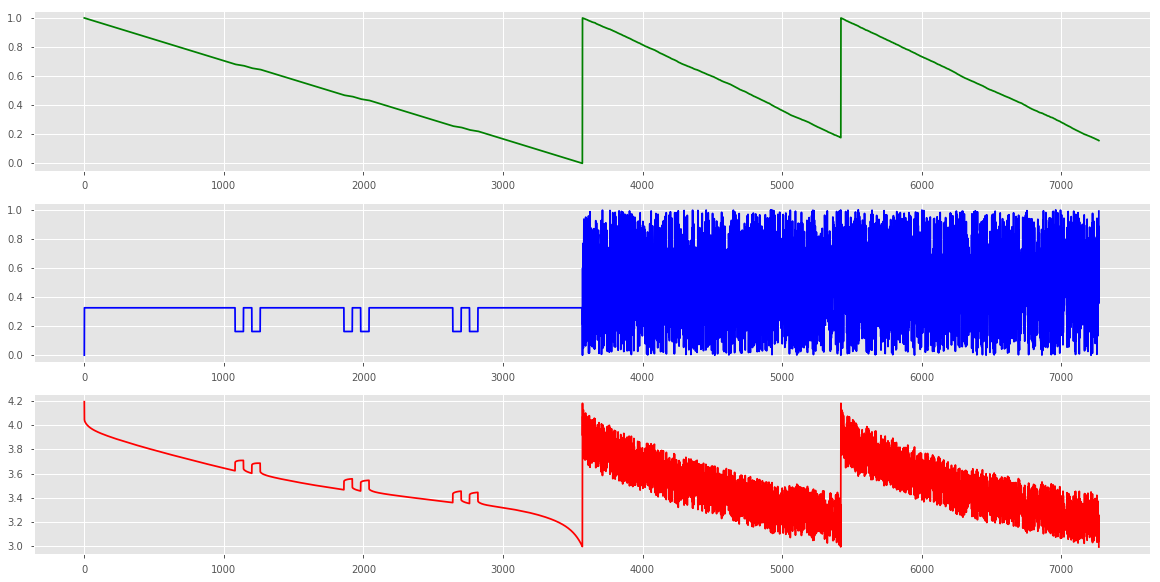

In [6]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC, '-g')
plt.subplot(312)
plt.plot(Current, '-b')
plt.subplot(313)
plt.plot(Voltage, '-r')
plt.show()

## 2. Create a Prior for the network

In [7]:
prior_set = Characterisation_Set['Sets'][0]
SoC_prior_out = scale_prior(prior_set['SoC'].T, SoC_min, SoC_max)
Current_prior = scale_prior(prior_set['Current'].T, Current_min, Current_max)
Voltage_prior = prior_set['Voltage'].T

In [8]:
SoC_prior_in = np.concatenate(([[1.0]], SoC_prior_out[0:-1]))

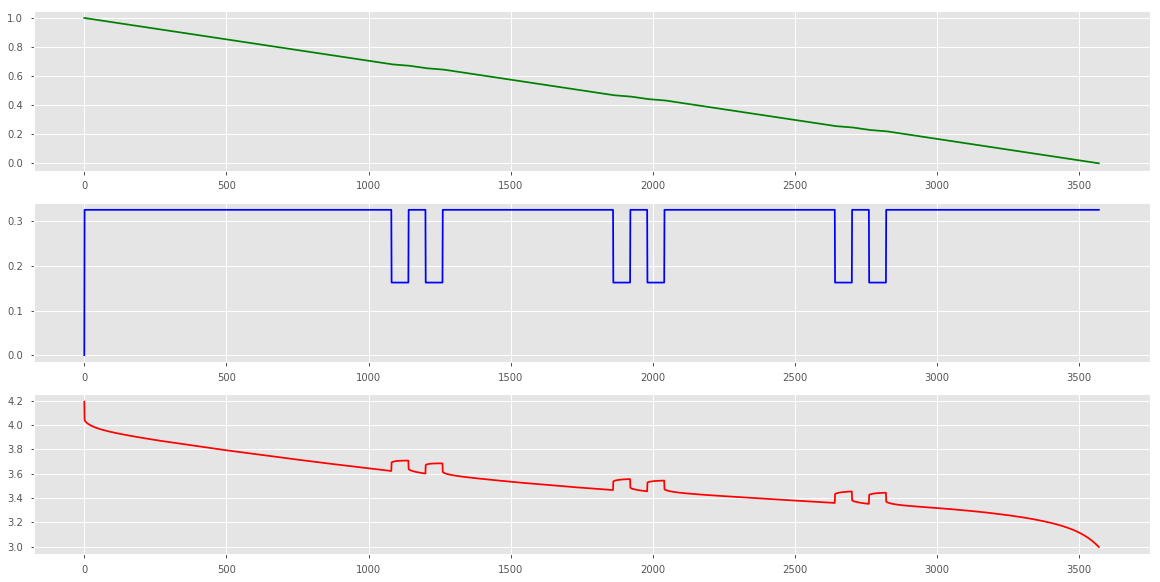

In [9]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC_prior_out, '-g')
plt.subplot(312)
plt.plot(Current_prior, '-b')
plt.subplot(313)
plt.plot(Voltage_prior, '-r')
plt.show()

In [10]:
class Pretrain_Network(nn.Module):
    def __init__(self, p=0.25):
        super(Pretrain_Network, self).__init__()
        self.p = p
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        
        self.Voc_hl1 = nn.Linear(1, 1024)
        self.Voc_hl2 = nn.Linear(1024, 512)
        self.VoC = nn.Linear(512, 1)
                
    def forward(self, soc, current):
        I = torch.Tensor([[current]])
        I = I.to(device, torch.float)
        soc_in = torch.Tensor([[soc]])
        soc_in = soc_in.to(device, torch.float)
        # Estimate VoC
        VoC = torch.sigmoid(self.Voc_hl1(soc_in))
        VoC = F.dropout(VoC, training=self.training, p=self.p)
        VoC = torch.sigmoid(self.Voc_hl2(VoC))
        VoC = F.dropout(VoC, training=self.training, p=self.p)
        VoC = self.VoC(VoC)

        # Estimate Z_p
        combined = torch.cat((soc_in, I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = F.dropout(Z, training=self.training, p=self.p)
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = F.dropout(Z, training=self.training, p=self.p)
        Z = self.Z_p(Z)

        # Estimate V
        scaled_I = I*(Current_max - Current_min) + Current_min
        V = VoC - scaled_I*Z
        
        return V
    

In [11]:
prior = Pretrain_Network()
# init
for W in prior.parameters():
    nn.init.normal_(W)

# Loss and optimizer
criterion1 = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(prior.parameters(), weight_decay=0.00025) 

In [12]:
# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
prior.to(device)

Pretrain_Network(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
  (Voc_hl1): Linear(in_features=1, out_features=1024, bias=True)
  (Voc_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (VoC): Linear(in_features=512, out_features=1, bias=True)
)

In [13]:
print(Voltage_prior.shape)

(3570, 1)


In [14]:
import time
import math

epochs = 500
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
prior.train()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

for epoch in range(epochs):
    count = -1
    avg_loss = 0
    
    for i in range(Voltage_prior.shape[0]):
        V = torch.Tensor([[Voltage_prior[i, 0]]])
        optimizer.zero_grad()
        V_est = prior(SoC_prior_in[i, 0], Current_prior[i, 0])
        loss = criterion1(V_est.to('cpu'), V)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= float(Voltage_prior.shape[0])
    if epoch % 5 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        print("New average minimum: ", avg_loss)
        torch.save(prior.state_dict(), "./Battery_Data/new_battery_cycles/Battery_RNN_prior_v1.mdl")
        loss_min = avg_loss

epoch 0, time since start: 0m 8s, estimated remaining time: 1h 10m 47s
New average minimum:  514.4454815843573
New average minimum:  318.95396509217716
New average minimum:  232.3365267882471
New average minimum:  183.74397329382643
New average minimum:  143.34755081645716
epoch 5, time since start: 0m 49s, estimated remaining time: 1h 7m 25s
New average minimum:  103.82461828967597
New average minimum:  74.47849047278613
New average minimum:  56.65818507958248
New average minimum:  42.14010695928847
New average minimum:  27.981999333602747
epoch 10, time since start: 1m 29s, estimated remaining time: 1h 6m 16s
New average minimum:  17.52837832382876
New average minimum:  11.551014739236997
New average minimum:  6.779271805688202
New average minimum:  3.0685715327080265
New average minimum:  0.9020239289953669
epoch 15, time since start: 2m 9s, estimated remaining time: 1h 5m 26s
New average minimum:  0.21135739175782425
New average minimum:  0.10148780917688704
New average minimum:  0

epoch 330, time since start: 44m 41s, estimated remaining time: 0h 22m 49s
epoch 335, time since start: 45m 21s, estimated remaining time: 0h 22m 8s
epoch 340, time since start: 46m 1s, estimated remaining time: 0h 21m 27s
epoch 345, time since start: 46m 41s, estimated remaining time: 0h 20m 46s
epoch 350, time since start: 47m 21s, estimated remaining time: 0h 20m 6s
epoch 355, time since start: 48m 1s, estimated remaining time: 0h 19m 25s
epoch 360, time since start: 48m 41s, estimated remaining time: 0h 18m 44s
epoch 365, time since start: 49m 21s, estimated remaining time: 0h 18m 4s
epoch 370, time since start: 50m 1s, estimated remaining time: 0h 17m 23s
epoch 375, time since start: 50m 41s, estimated remaining time: 0h 16m 43s
epoch 380, time since start: 51m 21s, estimated remaining time: 0h 16m 2s
epoch 385, time since start: 52m 1s, estimated remaining time: 0h 15m 21s
epoch 390, time since start: 52m 41s, estimated remaining time: 0h 14m 41s
epoch 395, time since start: 53m 

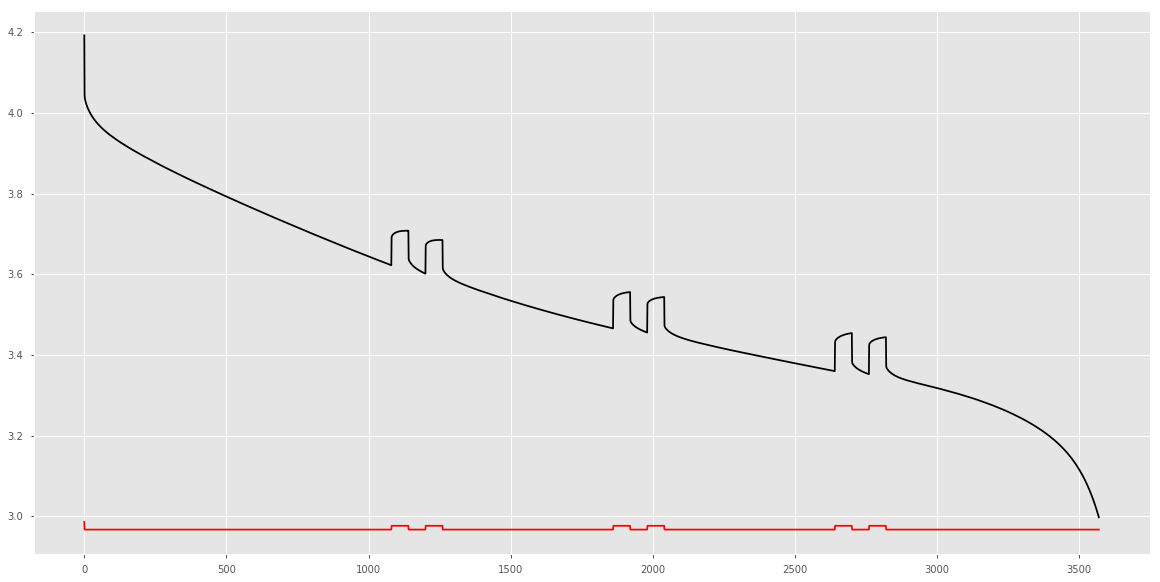

In [15]:
prior = Pretrain_Network()
prior.load_state_dict(torch.load("./Battery_Data/new_battery_cycles/Battery_RNN_prior_v1.mdl"))
prior.to(device)
prior.eval()

with torch.no_grad():   
    V_est_hist = []
    for i in range(Voltage_prior.shape[0]):
        V_est = prior(SoC_prior_in[i, 0], Current_prior[i, 0])
        V_est_hist.append(V_est.item())
plt.figure()
plt.plot(Voltage_prior, 'k')
plt.plot(V_est_hist, 'r')
